In [17]:
#!git clone https://github.com/tayfununal/hamiltonian.git

In [18]:
# Required packages

import numpy as np
import matplotlib.pyplot as plt

%run symplectic_euler.ipynb

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

In [19]:
class Hamiltonian:
    "Energy preserved neural network"
    def __init__(self, solver, input_dim, output_dim, hidden_layer, each_neuron, activation_func, epoch,
                     batch_size, learning_rate):
        
        self.T, self.V, self.z, self.t, self.t_interval, self.initial_point, self.h = solver

        # Neural Network Model with MSE Loss
        self.model = self.NN(inputs =input_dim, output=output_dim, hidden_layer=hidden_layer, neuron=each_neuron,
                                     activation=activation_func)
        self.model_train = self.train(model=self.model, inputs=self.t, target=self.z, learning_rate=learning_rate,
                                    batch_size=batch_size, epochs=epoch)
        
        #Neural Network Model with Energy Preserved Loss
        
        self.energy_model = self.NN(inputs= input_dim,output=output_dim, hidden_layer=hidden_layer, neuron=each_neuron,
                                        activation=activation_func)

        # Parametreleri atama ve veri arttırma
        self.energy_model.set_weights(self.model_train.get_weights())
        t_created = np.arange(float(self.t_interval[0]), float(self.t_interval[1]), 0.001)
        target_created = self.model_train(t_created)
        
        self.energy_model_train = self.train(model=self.energy_model, inputs=t_created, target=target_created,
                                             learning_rate=learning_rate, loss=self.custom_loss, batch_size=batch_size,
                                             epochs=epoch)
    
    # Hamiltonian function

    def H(self, T, V, q, p):
        return T(p) + V(q)

    # Neural network with MSE loss
    def NN(self, inputs, output, hidden_layer, neuron, activation="relu"):
        np.random.seed(1)
        tf.random.set_seed(1)
        
        inp = Input(shape=(inputs,), name= "Input_Layer")
        for i in range(0, hidden_layer):
            if i == 0:
                x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(inp)
            else:
                x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(x)
        x = Dense(output, name="Output_Layer")(x)

        out = tf.constant([[self.initial_point[0],self.initial_point[1]]],
                              dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x

        return Model(inputs=inp, outputs=out)

    # Neural Network Model Compile and Fit
    def train(self, model, inputs, target, learning_rate=0.0003, loss="mse", batch_size=32, epochs=1000):
        
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(optimizer=opt, loss=loss)
        model.fit(x=inputs, y=target, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=True)
        
        return model

    def custom_loss(self, y_true, y_pred):
        return tf.keras.losses.MSE(0.5, self.H(self.T, self.V, y_pred[None,:,0], y_pred[None, :,1])) +  0.001 * tf.keras.losses.MSE(y_true,y_pred)


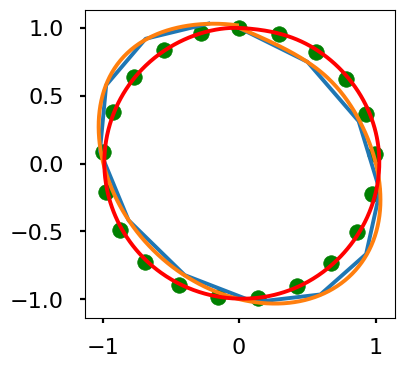

In [22]:
"""
def T(p):
    return (p**2)/2

def V(q):
    return (q**2)/2

model = Hamiltonian(solver=symplectic_euler(T, V, initial_point=[0.,1.], t_interval=[0,2*np.pi], h=0.5), input_dim=1, output_dim=2,
            hidden_layer=20, each_neuron=64, activation_func=tf.math.sin, epoch=2000 ,batch_size=100000000, learning_rate=0.0002)


plt.figure(figsize = (4, 4))

test_t = np.arange(0,2*np.pi,0.01)
prediction_energy = model.energy_model_train(test_t)
prediction_mse = model.model_train(test_t)

# grand-truth
plt.scatter(tf.math.sin(np.arange(0.,2*np.pi,0.3)), tf.math.cos(np.arange(0.,2*np.pi,0.3)), c="green")
# symplectic euler
plt.plot(model.z[:,0], model.z[:,1])
# NN with mse
plt.plot(prediction_mse[:,0], prediction_mse[:,1])
# NN with energy loss
plt.plot(prediction_energy[:,0], prediction_energy[:,1], c="red")
"""